In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss

Using TensorFlow backend.


In [2]:
df = pd.read_pickle('data/df.pickle')
df = df.loc[(df['Name']!='David Moore')]
df = df.loc[(df['Name']!='Josh Jackson')]
df = df.loc[(df['Name']!='Cameron Smith')]
df = df.loc[(df['Name']!='Josh Allen')]
df = df.loc[(df['Name']!='Braden Smith')]
df.reset_index(drop=True,inplace=True)

In [3]:
dummies = ['Category', 'Yr']
pd.get_dummies(df, columns=dummies)

,Name,Pos,Ht,Wt,Kickoffs,Punts,TD,FG,1XP,2XP,...,Category_Offensive Lineman,Category_Quarterback,Category_Receiver,Category_Running Back,Category_linebackers,Yr_-,Yr_FR,Yr_JR,Yr_SO,Yr_SR
0,Jaleel Awini,WR,74,215.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,Chidobe Awuzie,DB,72,205.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,David Bagby,WR,72,180.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,Mo Bandi,OL,77,270.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,Sam Bennion,OLB,77,230.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19737,Davon Wells-Ross,DE,77,205.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
19738,Miles Williams,CB,73,192.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
19739,Logan Wilson,LB,74,250.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
19740,Ben Wisdorf,LB,73,230.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0


In [4]:
df.columns

Index(['Name', 'Pos', 'Yr', 'Ht', 'Wt', 'Kickoffs', 'Punts', 'TD', 'FG', '1XP',
       '2XP', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.', 'Int.', 'Solo',
       'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int', 'Drafted',
       'Category'],
      dtype='object')

In [5]:
quarterback = df.loc[(df['Category']=='Quarterback')]
relevant_quarterback = quarterback[['Name', 'Yr', 'Ht', 'Wt', 'Pass Yards', 'Att',
                          'Comp', 'Passing TD', 'Passing Int', 'Drafted']]

In [6]:
offense = df.loc[(df['Category']=='Offense')]
relevant_offense = offense[['Name', 'Yr', 'Ht', 'Wt', 'TD', 
                            'Points', 'Rush Yards', 'Recv.', 'Drafted']]

In [7]:
offensive_lineman = df.loc[(df['Category']=='Offensive Lineman')]
relevant_offensive_lineman = offensive_lineman[['Name', 'Yr', 'Wt', 'Ht', 'Drafted']] 
                           

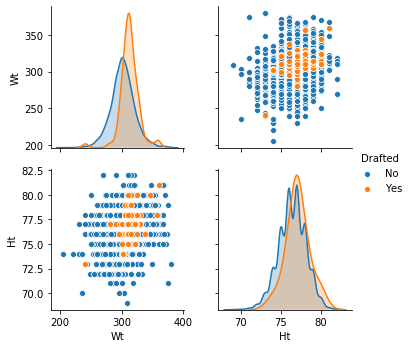

In [296]:
sns.pairplot(relevant_offensive_lineman, hue='Drafted')

In [221]:
defensive_zone = df.loc[(df['Category']=='Defensive Zone')]
relevant_defensive_zone = defensive_zone[['Name', 'Yr', 'Ht', 'Wt', 
                                          'Int.', 'Solo', 'Drafted']]

In [202]:
relevant_defensive_zone.loc[(relevant_defensive_zone['Yr']=='SO') 
                         & (relevant_defensive_zone['Drafted']=='Yes')]

,Name,Yr,Ht,Wt,Int.,Solo,Drafted
716,Howard Wilson,SO,73,185.0,5.0,45.0,Yes
1819,Malik Hooker,SO,74,205.0,7.0,43.0,Yes
1832,Marshon Lattimore,SO,72,192.0,4.0,30.0,Yes
18545,Greedy Williams,SO,75,184.0,2.0,23.0,Yes


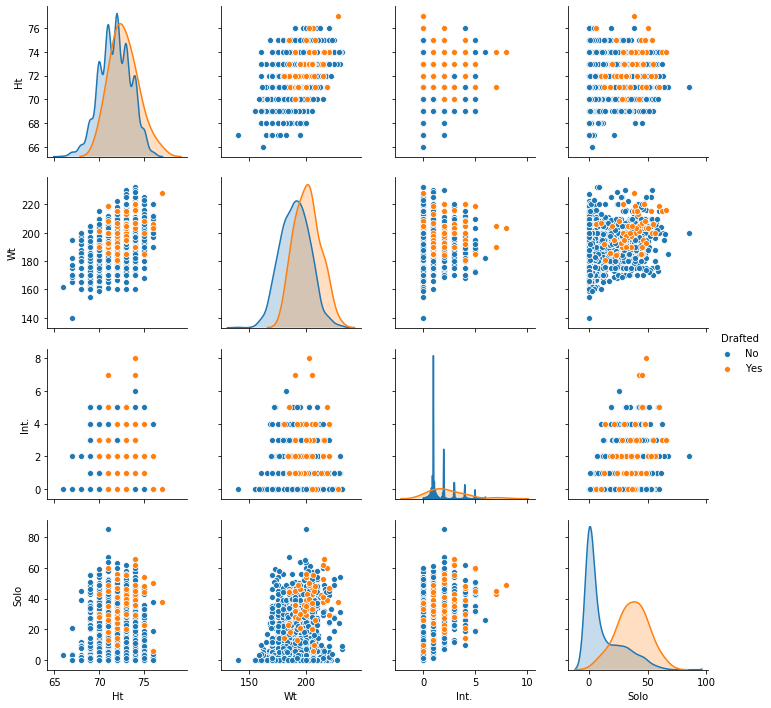

In [216]:
sns.pairplot(relevant_defensive_zone, hue='Drafted')

In [143]:
relevant_quarterback.loc[(relevant_quarterback['Yr']=='SO') 
                         & (relevant_quarterback['Drafted']=='Yes')]

,Name,Yr,Ht,Wt,Pass Yards,Att,Comp,Passing TD,Passing Int,Drafted
13704,Sam Darnold,SO,76,220.0,4143.0,480.0,303.0,26.0,13.0,Yes
15264,Dwayne Haskins,SO,75,220.0,4831.0,533.0,373.0,50.0,8.0,Yes


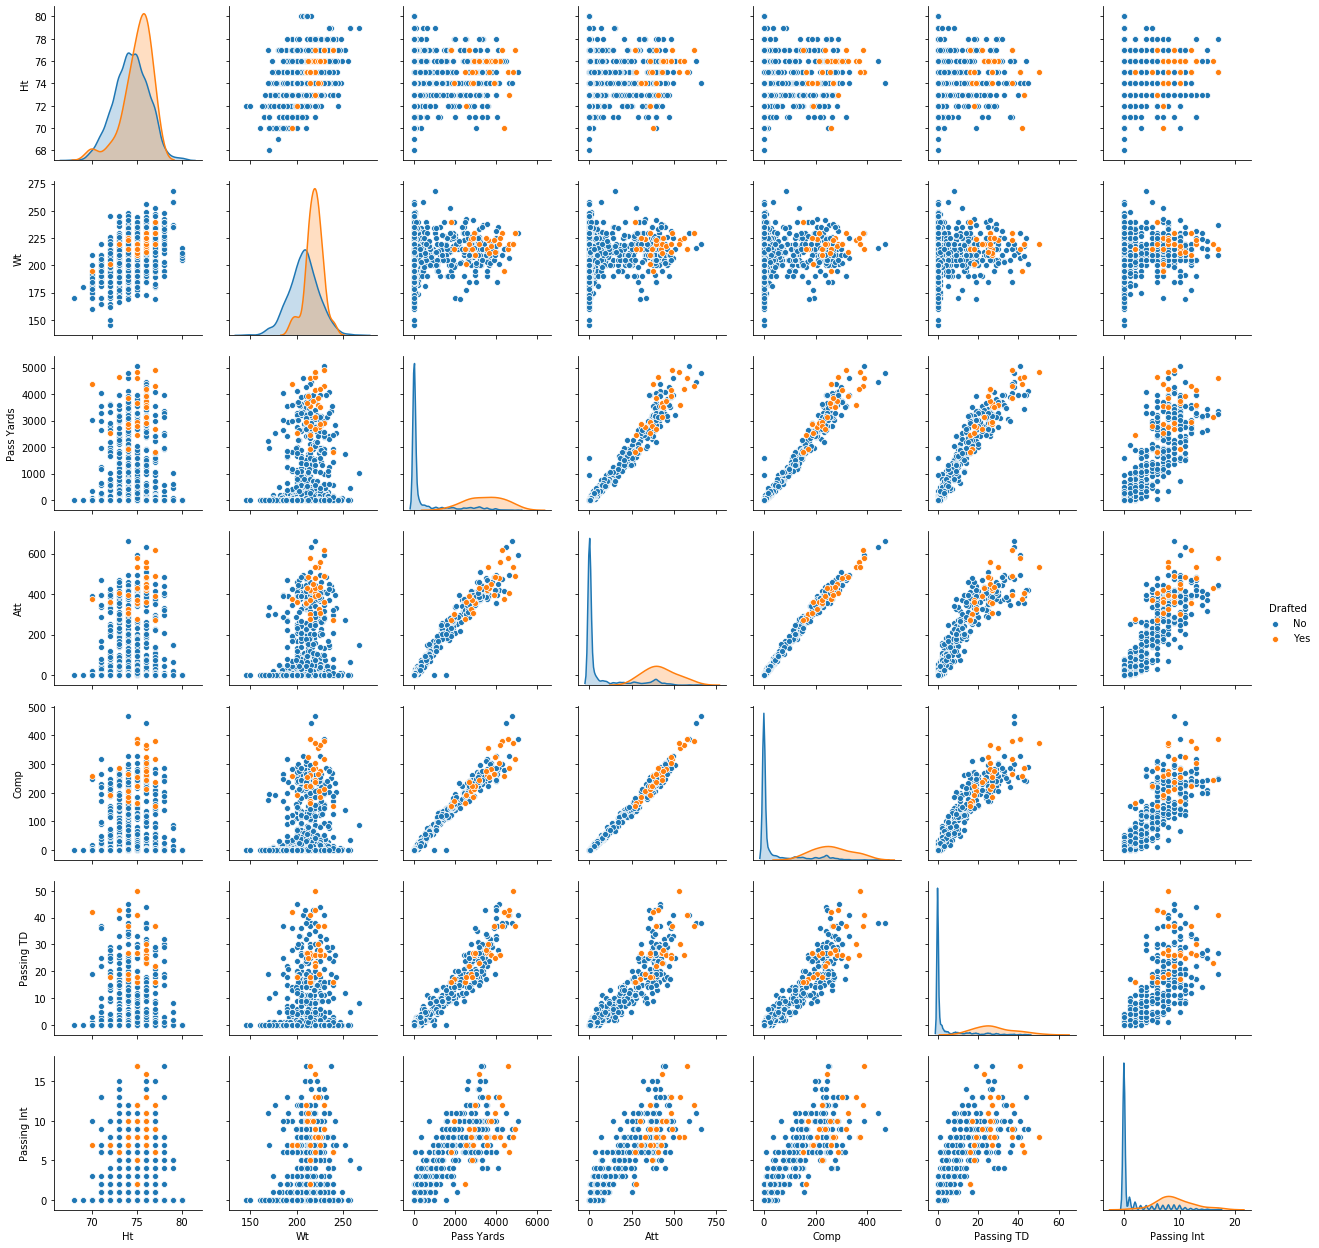

In [144]:
sns.pairplot(quarterback[['Yr', 'Ht', 'Wt', 'Pass Yards', 'Att',
                          'Comp', 'Passing TD', 'Passing Int', 'Drafted']], hue='Drafted')

In [8]:
X = df[['Yr', 'Ht', 'Wt', 'TD', '2XP', 'Points', 'Rush Yards', 
     'Pass Yards', 'Recv.', 'Int.', 'Solo', 'Sacks', 'Att', 'Comp',
     'Passing TD', 'Passing Int', 'Category']]
y = df['Drafted']

In [9]:
X = pd.get_dummies(X, columns=dummies)
X.columns

Index(['Ht', 'Wt', 'TD', '2XP', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.',
       'Int.', 'Solo', 'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int',
       'Category_Defense', 'Category_Defensive Zone',
       'Category_Offensive Lineman', 'Category_Quarterback',
       'Category_Receiver', 'Category_Running Back', 'Category_linebackers',
       'Yr_-', 'Yr_FR', 'Yr_JR', 'Yr_SO', 'Yr_SR'],
      dtype='object')

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, 
                                                            test_size =0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size =0.2, random_state=42)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train[['Ht', 'Wt', 'TD', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.', 
                   'Int.', 'Solo', 'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int']])
X_train = scaler.transform(X_train[['Ht', 'Wt', 'TD', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.', 
                   'Int.', 'Solo', 'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int']])
X_val = scaler.transform(X_val[['Ht', 'Wt', 'TD', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.', 
                   'Int.', 'Solo', 'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int']])

In [11]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros = pd.DataFrame(X_ros, columns = X_val.columns)

In [12]:
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
X_ada = pd.DataFrame(X_ada, columns = X_test.columns)

In [13]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm = pd.DataFrame(X_sm, columns = X_val.columns)

In [61]:
adaxgboost = XGBClassifier(min_child_weight=5, colsample_bytree=0.7, n_estimators = 100,
                           max_depth=3, subsample=1, learning_rate=0.1).fit(X_ada, y_ada)

In [62]:
adaxgboost.predict(X_val)
print(confusion_matrix(y_test, adaxgboost.predict(X_test)))
print("Precision: " , precision_score(y_val, adaxgboost.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, adaxgboost.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_test, adaxgboost.predict(X_test), pos_label='Yes'))
print("fbeta_score: " , fbeta_score(y_val, adaxgboost.predict(X_val),beta=1.5, pos_label='Yes',))


[[3607  219]
 [  38   85]]
Precision:  0.3004694835680751
Recall:  0.6666666666666666
f1_score:  0.3981264637002342
fbeta_score:  0.48484848484848486


In [14]:
smxgboost = XGBClassifier(min_child_weight=5, colsample_bytree=0.7, n_estimators = 100,
                           max_depth=5, subsample=1, learning_rate=0.1).fit(X_sm, y_sm)

In [15]:
smxgboost.predict(X_val)
print(confusion_matrix(y_val, smxgboost.predict(X_val)))
print("Precision: " , precision_score(y_val, smxgboost.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, smxgboost.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, smxgboost.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_train, smxgboost.predict(X_train), pos_label='Yes'))
print("fbeta_score: " , fbeta_score(y_val, smxgboost.predict(X_val),beta=1.0, pos_label='Yes',))


[[2971   92]
 [  46   50]]
Precision:  0.352112676056338
Recall:  0.5208333333333334
f1_score:  0.42016806722689076
f1_score:  0.5184304399524375
fbeta_score:  0.42016806722689076


ROC AUC score:  0.9357995973446511


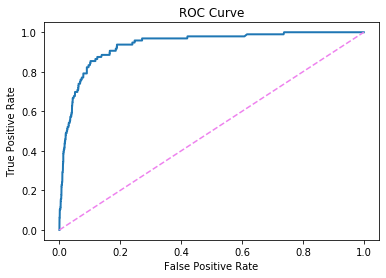

In [16]:
fpr, tpr, thresholds = roc_curve(y_val, smxgboost.predict_proba(X_val)[:,1],
                                 pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, smxgboost.predict_proba(X_val)[:,1]))

In [66]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train_val, y_train_val)
X_sm = pd.DataFrame(X_sm, columns = X_val.columns)

In [56]:
smxgboost = XGBClassifier(min_child_weight=3, colsample_bytree=0.7, n_estimators = 100,
                           max_depth=3, subsample=0.8, learning_rate=0.1).fit(X_sm, y_sm)

In [57]:
smxgboost.predict(X_test)
print(confusion_matrix(y_test, smxgboost.predict(X_test)))
print("Precision: " , precision_score(y_test, smxgboost.predict(X_test), pos_label='Yes'))
print("Recall: " , recall_score(y_test, smxgboost.predict(X_test), pos_label='Yes'))
print("f1_score: " , f1_score(y_test, smxgboost.predict(X_test), pos_label='Yes'))
print("f1_score: " , f1_score(y_train, smxgboost.predict(X_train), pos_label='Yes'))
print("fbeta_score: " , fbeta_score(y_test, smxgboost.predict(X_test),beta=1.0, pos_label='Yes',))


[[3617  209]
 [  39   84]]
Precision:  0.28668941979522183
Recall:  0.6829268292682927
f1_score:  0.40384615384615385
f1_score:  0.42139384116693673
fbeta_score:  0.40384615384615385


ROC AUC score:  0.9311790530346495


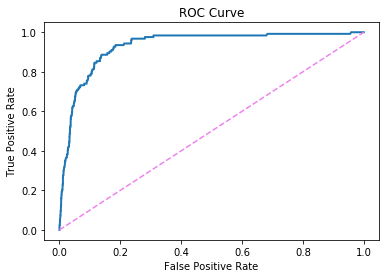

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, smxgboost.predict_proba(X_test)[:,1],
                                 pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_test, smxgboost.predict_proba(X_test)[:,1]))

In [47]:
insights = X_test.reset_index()
insights = insights.join(pd.DataFrame(smxgboost.predict(X_test)))
insights['predictions'] = insights[0]
insights = insights[['index', 'predictions']]

In [48]:
insights

,index,predictions
0,16396,No
1,15376,No
2,10638,No
3,7884,No
4,5689,No
...,...,...
3944,5382,No
3945,15474,No
3946,15173,No
3947,2087,Yes


In [49]:
df.reset_index(inplace=True)

In [50]:
predictions = df.merge(insights,how='outer',on='index')
drafted = predictions.loc[(predictions['Drafted']=='Yes')]
drafted = drafted.loc[(drafted['predictions']=='No')]
drafted

,level_0,index,Name,Pos,Yr,Ht,Wt,Kickoffs,Punts,TD,...,Int.,Solo,Sacks,Att,Comp,Passing TD,Passing Int,Drafted,Category,predictions
99,99,99,Alex Anzalone,LB,JR,75,241.0,0.0,0.0,0.0,...,0.0,22.0,3.0,0.0,0.0,0.0,0.0,Yes,linebackers,No
101,101,101,Caleb Brantley,DL,JR,74,297.0,0.0,0.0,0.0,...,0.0,16.0,2.5,0.0,0.0,0.0,0.0,Yes,Defense,No
361,361,361,Roderick Johnson,OL,JR,79,311.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Offensive Lineman,No
828,828,828,Brandon Wilson,DL,FR,75,261.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Yes,Defense,No
1163,1163,1163,Malachi Dupre,WR,JR,76,195.0,0.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Yes,Receiver,No
1576,1576,1576,Pat Elflein,OL,SR,75,300.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Offensive Lineman,No
2425,2425,2425,Khalfani Muhammad,RB,SR,69,175.0,0.0,0.0,2.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Yes,Running Back,No
2585,2585,2585,Adrian Colbert,DB,SR,74,205.0,0.0,0.0,0.0,...,1.0,13.0,0.0,0.0,0.0,0.0,0.0,Yes,Defense,No
2676,2676,2676,Jehu Chesson,WR,SR,75,203.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Receiver,No
2677,2677,2677,Jeremy Clark,CB,SR,76,206.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,Yes,Defensive Zone,No


In [76]:
drafted_preds = predictions.loc[(predictions['predictions']=='Yes')]
drafted_preds.loc[(drafted_preds['Drafted']=='No')].loc[(drafted_preds['Yr']=='JR')]

,level_0,index,Name,Pos,Yr,Ht,Wt,Kickoffs,Punts,TD,...,Int.,Solo,Sacks,Att,Comp,Passing TD,Passing Int,Drafted,Category,predictions
451,451,451,Aaron Davis,CB,JR,73,189.0,0.0,0.0,0.0,...,2.0,35.0,1.5,0.0,0.0,0.0,0.0,No,Defensive Zone,Yes
953,953,953,Jarred Craft,RB,JR,72,213.0,0.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Running Back,Yes
2046,2046,2046,Cedrick Wilson,WR,JR,75,183.0,0.0,0.0,11.0,...,0.0,1.0,0.0,2.0,2.0,1.0,0.0,No,Receiver,Yes
2664,2664,2664,Joseph Yearby,RB,JR,69,200.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Running Back,Yes
3784,3784,3784,Garrett Sickels,DE,JR,76,260.0,0.0,0.0,0.0,...,0.0,23.0,6.0,0.0,0.0,0.0,0.0,No,Defense,Yes
4037,4037,4037,Quinton Flowers,QB,JR,72,210.0,0.0,0.0,18.0,...,0.0,0.0,0.0,331.0,207.0,24.0,7.0,No,Quarterback,Yes
4049,4049,4049,Bruce Hector,DT,JR,74,296.0,0.0,0.0,0.0,...,0.0,20.0,6.0,0.0,0.0,0.0,0.0,No,Defense,Yes
4116,4116,4116,Mat Boesen,DE,JR,76,235.0,0.0,0.0,0.0,...,0.0,18.0,6.0,0.0,0.0,0.0,0.0,No,Defense,Yes
4936,4936,4936,Cody Thompson,WR,JR,74,200.0,0.0,0.0,11.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,No,Receiver,Yes
5535,5535,5535,Gerard Wicks,RB,JR,72,227.0,0.0,0.0,13.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,No,Running Back,Yes


In [59]:
drafted.columns

Index(['index', 'Name', 'Pos', 'Yr', 'Ht', 'Wt', 'Kickoffs', 'Punts', 'TD',
       'FG', '1XP', '2XP', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.',
       'Int.', 'Solo', 'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int',
       'Drafted', 'Category', 'predictions'],
      dtype='object')

In [543]:
df.iloc[9328]

Name           Karan Higdon
Pos                      RB
Yr                       JR
Ht                       70
Wt                      190
Kickoffs                  0
Punts                     0
TD                       11
FG                        0
1XP                       0
2XP                       0
Points                   66
Rush Yards              994
Pass Yards                0
Recv.                   131
Int.                      0
Solo                      0
Sacks                     0
Att                       0
Comp                      0
Passing TD                0
Passing Int               0
Drafted                  No
Category       Running Back
Name: 9328, dtype: object

In [549]:
gradient_boosting = GradientBoostingClassifier(max_depth=10).fit(X_ros, y_ros)

In [550]:
gradient_boosting.predict(X_val)
print(confusion_matrix(y_val, gradient_boosting.predict(X_val)))
print("Precision: " , precision_score(y_val, gradient_boosting.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, gradient_boosting.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, gradient_boosting.predict(X_val), pos_label='Yes'))

[[2988   75]
 [  57   39]]
Precision:  0.34210526315789475
Recall:  0.40625
f1_score:  0.3714285714285715


ROC AUC score:  0.9148166285776473


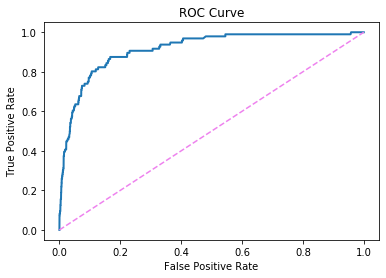

In [370]:
fpr, tpr, thresholds = roc_curve(y_val, gradient_boosting.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, gradient_boosting.predict_proba(X_val)[:,1]))

In [18]:
smgradient_boosting = GradientBoostingClassifier(max_depth=5, max_features='sqrt', learning_rate=0.1).fit(X_sm, y_sm)

NameError: name 'X_sm' is not defined

In [581]:
smgradient_boosting.predict(X_val)
print(confusion_matrix(y_train, smgradient_boosting.predict(X_train)))
print("f1_score: " , f1_score(y_train, smgradient_boosting.predict(X_train), pos_label='Yes'))
print(confusion_matrix(y_val, smgradient_boosting.predict(X_val)))
print("Precision: " , precision_score(y_val, smgradient_boosting.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, smgradient_boosting.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, smgradient_boosting.predict(X_val), pos_label='Yes'))

[[12096   188]
 [  113   237]]
f1_score:  0.6116129032258065
[[2983   80]
 [  48   48]]
Precision:  0.375
Recall:  0.5
f1_score:  0.42857142857142855


ROC AUC score:  0.9376479350310153


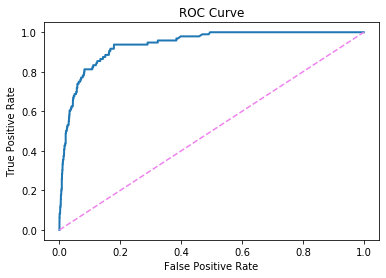

In [373]:
fpr, tpr, thresholds = roc_curve(y_val, smgradient_boosting.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, smgradient_boosting.predict_proba(X_val)[:,1]))

In [607]:
adagradient_boosting = GradientBoostingClassifier(max_depth=6, n_estimators=100).fit(X_ada, y_ada)

In [608]:
adagradient_boosting.predict(X_val)
print(confusion_matrix(y_val, adagradient_boosting.predict(X_val)))
print("Precision: " , precision_score(y_val, adagradient_boosting.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, adagradient_boosting.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, adagradient_boosting.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_train, adagradient_boosting.predict(X_train), pos_label='Yes'))

[[2997   66]
 [  52   44]]
Precision:  0.4
Recall:  0.4583333333333333
f1_score:  0.4271844660194175
f1_score:  0.7088607594936708


ROC AUC score:  0.9244426080095767


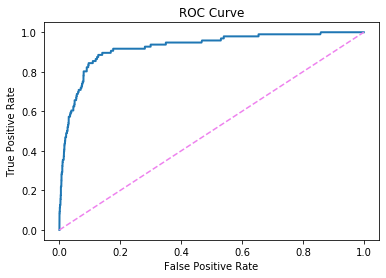

In [600]:
fpr, tpr, thresholds = roc_curve(y_val, adagradient_boosting.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, adagradient_boosting.predict_proba(X_val)[:,1]))

In [377]:
log = LogisticRegression(C=10000, solver='lbfgs').fit(X_ros, y_ros)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [378]:
log.predict(X_val)
print(confusion_matrix(y_val, log.predict(X_val)))
print("Precision: " , precision_score(y_val, log.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, log.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, log.predict(X_val), pos_label='Yes'))

[[2629  434]
 [  16   80]]
Precision:  0.1556420233463035
Recall:  0.8333333333333334
f1_score:  0.26229508196721313


ROC AUC score:  0.9185150043530308


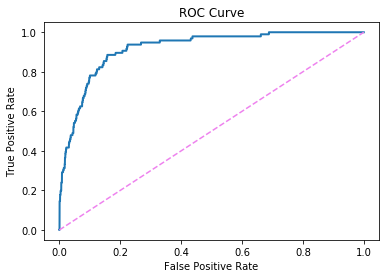

In [379]:
fpr, tpr, thresholds = roc_curve(y_val, log.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, log.predict_proba(X_val)[:,1]))

In [380]:
probas = log.predict_proba(X_val)
proba = pd.DataFrame(probas)[1]
logpred = proba > 0.4

In [381]:
print(len(proba))
print(len(y_val))

3159
3159


In [382]:
confusion_matrix(y_val=='Yes', logpred)

array([[2497,  566],
       [  10,   86]])

In [170]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_ros, y_ros)

In [171]:
print(confusion_matrix(y_val, knn.predict(X_val)))
print("Precision: " , precision_score(y_val, knn.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, knn.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, knn.predict(X_val), pos_label='Yes'))

[[2911  152]
 [  53   43]]
Precision:  0.2205128205128205
Recall:  0.4479166666666667
f1_score:  0.29553264604810997


In [55]:
probas = knn.predict_proba(X_val)
proba = pd.DataFrame(probas)[1]
knnpred = proba > 0.5

ROC AUC score:  0.7464750652954619


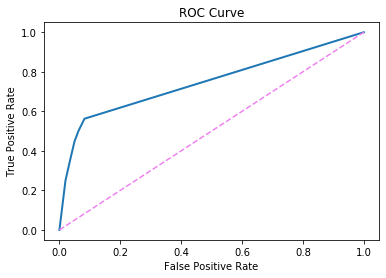

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]))

In [27]:
svm = SVC(probability=True, C=1, kernel='sigmoid').fit(X_ros, y_ros)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [29]:
print(confusion_matrix(y_val, svm.predict(X_val)))
print("Precision: " , precision_score(y_val, svm.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, svm.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, svm.predict(X_val), pos_label='Yes'))

[[3001   62]
 [  86   10]]
Precision:  0.1388888888888889
Recall:  0.10416666666666667
f1_score:  0.11904761904761905


In [30]:
probas = svm.predict_proba(X_val)
proba = pd.DataFrame(probas)[1]
svmpred = proba > 0.5

ROC AUC score:  0.45739471106758084


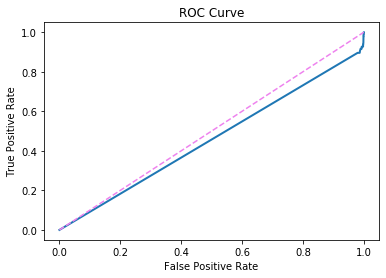

In [32]:
fpr, tpr, thresholds = roc_curve(y_val, svm.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, svm.predict_proba(X_val)[:,1]))

In [434]:
forest = RandomForestClassifier(max_depth=10, n_estimators=100).fit(X_ros, y_ros)

In [582]:
print(confusion_matrix(y_val, forest.predict(X_val)))
print("Precision: " , precision_score(y_val, forest.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, forest.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, forest.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_train, forest.predict(X_train), pos_label='Yes'))

[[2776  287]
 [  24   72]]
Precision:  0.20055710306406685
Recall:  0.75
f1_score:  0.3164835164835165
f1_score:  0.3933294997124784


In [385]:
probas = forest.predict_proba(X_val)
proba = pd.DataFrame(probas)[1]
forestpred = proba > 0.5

ROC AUC score:  0.9236281151376646


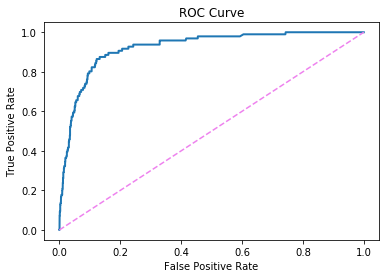

In [386]:
fpr, tpr, thresholds = roc_curve(y_val, forest.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

In [388]:
smlog = LogisticRegression(C=10000, solver='lbfgs').fit(X_sm, y_sm)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [389]:
smlog.predict(X_val)
print(confusion_matrix(y_val, smlog.predict(X_val)))
print("Precision: " , precision_score(y_val, smlog.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, smlog.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, smlog.predict(X_val), pos_label='Yes'))

[[2671  392]
 [  15   81]]
Precision:  0.17124735729386892
Recall:  0.84375
f1_score:  0.28471001757469244


In [390]:
probas = smlog.predict_proba(X_val)
proba = pd.DataFrame(probas)[1]
smlogpred = proba > 0.4

ROC AUC score=  0.9265783137446948


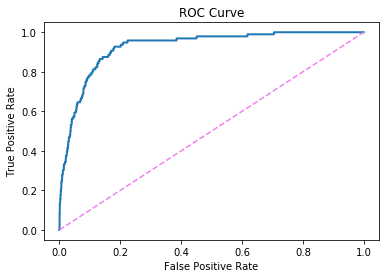

In [391]:
fpr, tpr, thresholds = roc_curve(y_val, smlog.predict_proba(X_val)[:,1], pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score= ' , roc_auc_score(y_val, smlog.predict_proba(X_val)[:,1]))

In [421]:
smlogcv = LogisticRegressionCV(Cs=[0.01, 1, 100, 10000], cv=5,
                           solver='sag', max_iter = 1000, verbose=True, 
                               random_state=42).fit(X_sm, y_sm)
smlogcv_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6 seconds


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 6 seconds
max_iter reached after 5 seconds


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 5 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 5 seconds


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 5 seconds
max_iter reached after 6 seconds


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 5 seconds
max_iter reached after 6 seconds
max_iter reached after 5 seconds
max_iter reached after 6 seconds


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 5 seconds


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [424]:
smlogcv.C_

array([10000.])

In [422]:
smlogcv.predict(X_val)
print(confusion_matrix(y_val, smlogcv.predict(X_val)))
print("Precision: " , precision_score(y_val, smlogcv.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, smlogcv.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, smlogcv.predict(X_val), pos_label='Yes'))

[[2640  423]
 [  18   78]]
Precision:  0.15568862275449102
Recall:  0.8125
f1_score:  0.2613065326633166


ROC AUC score=  0.9203140303623898


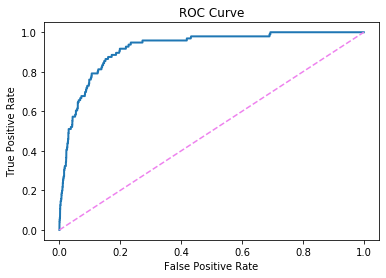

In [425]:
fpr, tpr, thresholds = roc_curve(y_val, smlogcv.predict_proba(X_val)[:,1], pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score= ' , roc_auc_score(y_val, smlogcv.predict_proba(X_val)[:,1]))

In [392]:
confusion_matrix(y_val=='Yes', smlogpred)

array([[2571,  492],
       [  11,   85]])

In [567]:
smforest = RandomForestClassifier(max_depth=16, n_estimators=100).fit(X_sm, y_sm)

In [568]:
smforest.predict(X_val)
print(confusion_matrix(y_val, smforest.predict(X_val)))
print("Precision: " , precision_score(y_val, smforest.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, smforest.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, smforest.predict(X_val), pos_label='Yes'))

[[2997   66]
 [  55   41]]
Precision:  0.38317757009345793
Recall:  0.4270833333333333
f1_score:  0.4039408866995074


ROC AUC score=  0.9249697328327349


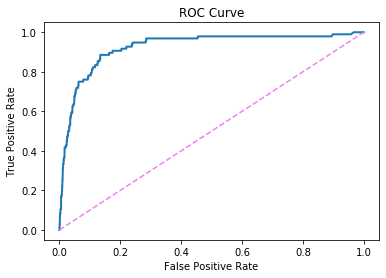

In [396]:
fpr, tpr, thresholds = roc_curve(y_val, smforest.predict_proba(X_val)[:,1], pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score= ' , roc_auc_score(y_val, smforest.predict_proba(X_val)[:,1]))

In [11]:
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
X_ada = pd.DataFrame(X_ada, columns = X_val.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [591]:
adalog = LogisticRegression(C=10000, solver='lbfgs').fit(X_ada, y_ada)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [399]:
adalog.predict(X_val)
print(confusion_matrix(y_val, adalog.predict(X_val)))
print("Precision: " , precision_score(y_val, adalog.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, adalog.predict(X_val), pos_label='Yes'))
print("f1 score: " , f1_score(y_val, adalog.predict(X_val), pos_label='Yes'))

[[2644  419]
 [  14   82]]
Precision:  0.16367265469061876
Recall:  0.8541666666666666
f1 score:  0.27470686767169183


In [400]:
probas = adalog.predict_proba(X_val)
proba = pd.DataFrame(probas)[1]
adalogpred = proba > 0.4

ROC AUC score:  0.9248983159212101


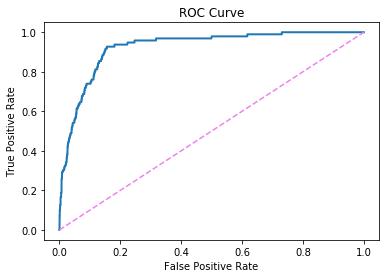

In [401]:
fpr, tpr, thresholds = roc_curve(y_val, adalog.predict_proba(X_val)[:,1] ,pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score: ' , roc_auc_score(y_val, adalog.predict_proba(X_val)[:,1]))

In [402]:
confusion_matrix(y_val=='Yes', adalogpred)
# print("Precision: " , precision_score(y_val, adalog.predict(X_val), pos_label='Yes'))
# print("Recall: " , recall_score(y_val, adalog.predict(X_val), pos_label='Yes'))
# print("f1_score: " , f1_score(y_val, adalog.predict(X_val), pos_label='Yes'))

array([[2526,  537],
       [   7,   89]])

In [452]:
adaforest = RandomForestClassifier(max_depth=11, n_estimators=100).fit(X_ada, y_ada)

In [453]:
adaforest.predict(X_val)
print(confusion_matrix(y_val, adaforest.predict(X_val)))
print("Precision: " , precision_score(y_val, adaforest.predict(X_val), pos_label='Yes'))
print("Recall: " , recall_score(y_val, adaforest.predict(X_val), pos_label='Yes'))
print("f1_score: " , f1_score(y_val, adaforest.predict(X_val), pos_label='Yes'))

[[2936  127]
 [  37   59]]
Precision:  0.3172043010752688
Recall:  0.6145833333333334
f1_score:  0.41843971631205673


ROC AUC score=  0.9245599357927957


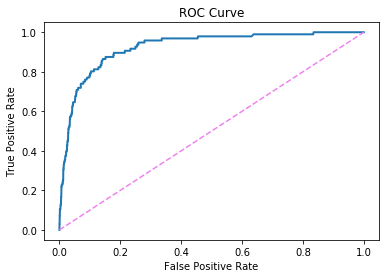

In [405]:
fpr, tpr, thresholds = roc_curve(y_val, adaforest.predict_proba(X_val)[:,1], pos_label = 'Yes')

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print('ROC AUC score= ' , roc_auc_score(y_val, adaforest.predict_proba(X_val)[:,1]))

In [588]:
models1 = ['smgradient_boosting', 'smforest', 'smlog', 'smxgboost']
models2 = ['adalog' ,'adagradient_boosting', 'adaxgboost']

In [594]:
for model_name in models1:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_sm, y_sm)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
         pickle.dump(curr_model, pfile)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [595]:
for model_name in models2:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_ada, y_ada)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
         pickle.dump(curr_model, pfile)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [347]:
!mkdir models

In [349]:
import pickle

In [65]:
data = {1: 4, 2: 4, 3: 4, 4: 6, 5: 5, 6: 7, 7: 8}

NameError: name 'key' is not defined